In [1]:
import pandas as pd
import numpy as np 
import re
import networkx as nx 
from community import community_louvain
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/mnt/39b89ea8-8334-43c3-b50b-918be75d4569/Dropbox/Momolbox/code/libro/4.capitolo_rep_na/scopusdigital_methods.csv')

In [3]:
len(df)

20000

In [4]:
df.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Volume',
       'Issue', 'Art. No.', 'Page start', 'Page end', 'Page count', 'Cited by',
       'DOI', 'Link', 'Document Type', 'Publication Stage', 'Open Access',
       'Source', 'EID'],
      dtype='object')

In [5]:
df['Cited by'] = df['Cited by'].fillna(0)

## analisi base

<AxesSubplot:title={'center':'N di articoli per rivista'}>

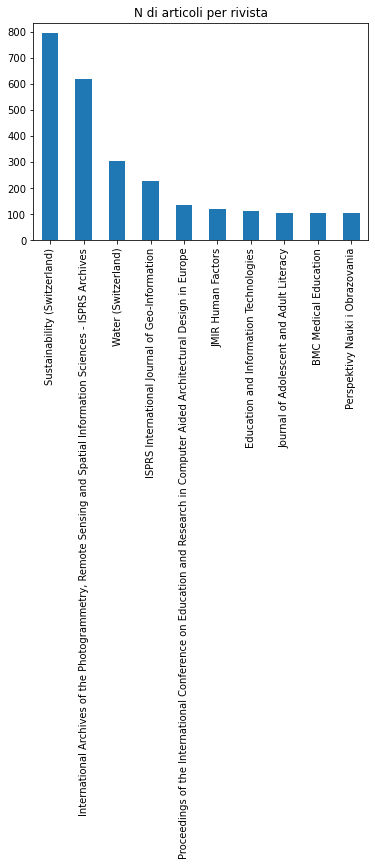

In [6]:
journals = df['Source title'].value_counts()

journals.head(10).plot(kind='bar',title='N di articoli per rivista')

In [7]:
#somma delle citazioni

piv_cit = pd.pivot_table(df, index='Source title',values='Cited by',aggfunc=sum)
piv_cit.sort_values(by='Cited by', ascending=False)

,Cited by
Source title,
Sustainability (Switzerland),6703.0
"International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences - ISPRS Archives",3530.0
Computers and Education,3309.0
Water (Switzerland),2347.0
Earth Surface Processes and Landforms,2343.0
...,...
Revista Bioetica,0.0
"Acta Scientiarum Polonorum, Administratio Locorum",0.0
Revista Brasileira de Direito Processual Penal,0.0


In [8]:
#media delle citazioni

piv_cit = pd.pivot_table(df, index='Source title',values='Cited by',aggfunc=np.mean)
piv_cit.sort_values(by='Cited by', ascending=False).head(10)

,Cited by
Source title,
"5th International Conference on Learning Representations, ICLR 2017 - Conference Track Proceedings",577.000000
Transportation Research Part E: Logistics and Transportation Review,443.000000
Improving Schools,322.000000
Socio-Economic Review,255.000000
"10th IEEE International Workshop on Information Forensics and Security, WIFS 2018",236.500000
SIGCOMM 2016 - Proceedings of the 2016 ACM Conference on Special Interest Group on Data Communication,207.000000
"6th International Conference on Learning Representations, ICLR 2018 - Workshop Track Proceedings",138.000000
NJAS - Wageningen Journal of Life Sciences,125.666667
Library Review,125.500000


<AxesSubplot:title={'center':'N di articoli per anno di pubblicazione'}>

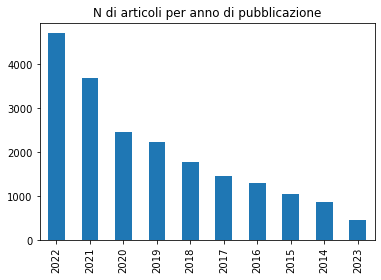

In [9]:
years = df['Year'].value_counts()
years.plot(kind='bar', title='N di articoli per anno di pubblicazione')

In [10]:
df['Cited by'] = df['Cited by'].fillna(0)

df['Year'] = pd.to_datetime(df['Year'],format ='%Y')

yearly_cit = df.resample('Y', on='Year')['Cited by'].sum()

<AxesSubplot:title={'center':'N citations per year'}, xlabel='Year'>

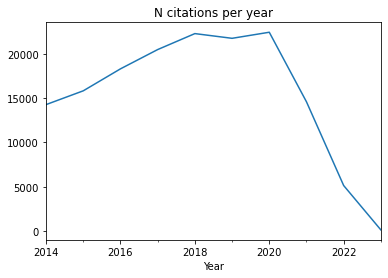

In [11]:
yearly_cit.plot(title= 'N citations per year')

## Creazione grafo

In [12]:
# preparazioni per NA


aut_ids = df['Author(s) ID'].tolist()

In [13]:
# crea lista di tuple a partire da df
edges=[]

for row in aut_ids: 
    if ';' in row:
        row_r = row.split(';')
        
        row_r = [row.strip() for row in row_r]
        
        for edge in combinations(row_r,2):
            if edge[0] == edge[1]:
                break
            edges.append(edge)
        
        
    else:
        pass



In [14]:
nodes=[]

# crea lista di nodi

for edge in edges: 
    for node in edge: 
        nodes.append(node)
        
nodes = list(set(nodes))

#mappa su dizionario con integers



node_dic ={ node: n for n, node in enumerate(nodes)}

#crea lista di edge con integers

edge_l_int = [(node_dic[edge[0]],node_dic[edge[1]])for edge in edges]

In [15]:
last_node_value = list(node_dic.values())[-1]

In [16]:
# genera dataframe per comodità

nodes_df = pd.DataFrame(nodes, columns=['id_scopus'])
nodes_df['node_id'] = nodes_df['id_scopus'].apply(lambda x: node_dic[x])

nodes_df

,id_scopus,node_id
0,55352961000,0
1,57210437927,1
2,56993448000,2
3,57205027320,3
4,57216157959,4
...,...,...
56246,57222557647,56246
56247,7003882091,56247
56248,57218103841,56248
56249,57215598514,56249


In [17]:
# crea grafo con networkx


G = nx.Graph()

for edge in edge_l_int: 
        G.add_edge(edge[0],edge[1])

In [18]:
# overview di grafo

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

avg_degree = sum(dict(G.degree()).values()) / float(num_nodes)
clustering = nx.average_clustering(G)
#diameter = nx.diameter(G)
assortativity = nx.degree_assortativity_coefficient(G)
num_components = nx.number_connected_components(G)

density = nx.density(G)

In [19]:
print('n nodes: '+ str(num_nodes))
print('n edges: '+ str(num_edges))
print('clustering:' +str(clustering))
print('assortativity: '+str(assortativity))
print('n components: '+str(num_components))
print('density: '+str(density))


n nodes: 56251
n edges: 123259
clustering:0.829636891744492
assortativity: 0.9375551348449938
n components: 12367
density: 7.791047665325456e-05


In [20]:
degree = dict(G.degree())

In [21]:
nodes_df['degree'] = nodes_df['node_id'].apply(lambda x: degree[x])

In [22]:
nodes_df.sort_values(by='degree', ascending = False)

,id_scopus,node_id,degree
4846,36931090200,4846,59
11550,7006538249,11550,59
15948,55878994300,15948,57
13521,57580651300,13521,56
46564,57216358883,46564,56
...,...,...,...
16877,55574208137,16877,1
16885,57202282253,16885,1
49849,57327886100,49849,1
49848,35789922500,49848,1


In [23]:
part = community_louvain.best_partition(G)
communities =pd.DataFrame.from_dict(part,orient='index', columns=['community'])
communities.reset_index(inplace=True)

In [24]:
comm_count = communities.community.value_counts()
comm_count

509     239
115     226
14      135
1245    134
83      129
       ... 
1858      2
7842      2
7839      2
1863      2
0         2
Name: community, Length: 12369, dtype: int64

In [25]:
nodes_df['community'] = nodes_df['node_id'].apply(lambda x: part[x])

In [26]:
nodes_df

,id_scopus,node_id,degree,community
0,55352961000,0,2,4057
1,57210437927,1,2,1017
2,56993448000,2,1,6153
3,57205027320,3,2,7088
4,57216157959,4,6,2630
...,...,...,...,...
56246,57222557647,56246,2,8227
56247,7003882091,56247,5,200
56248,57218103841,56248,1,7078
56249,57215598514,56249,6,2276


In [27]:
nodes_df['community'].value_counts()

509      239
115      226
14       135
1245     134
83       129
        ... 
10397      2
1897       2
10820      2
5356       2
11636      2
Name: community, Length: 12369, dtype: int64

<AxesSubplot:>

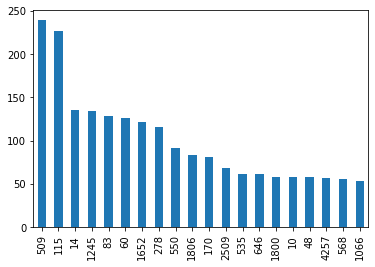

In [28]:
nodes_df['community'].value_counts().head(20).plot(kind='bar')

## calcolo powerlaw

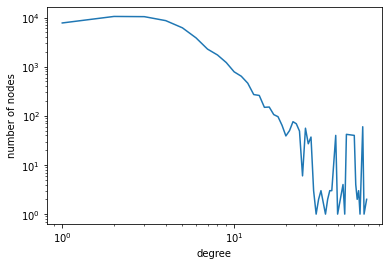

In [30]:
scores = sorted(nodes_df['degree'].tolist(), reverse=True)


degr, n_nodes = np.unique(scores, return_counts=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(degr, n_nodes)
plt.show()

In [31]:
#!pip install powerlaw

import powerlaw

fit = powerlaw.Fit(scores)

Calculating best minimal value for power law fit


In [32]:
fit.alpha

3.915389637240797

In [33]:
fit.distribution_compare('power_law','exponential')

(741.9135708561637, 4.405581425548143e-107)

## contenuto delle top 5 comunità

In [35]:
top_5_comm = comm_count.head(5).index.tolist()
top_5_comm

[509, 115, 14, 1245, 83]

In [36]:
top_c_nodes = {}

for comm in top_5_comm:
    df_t = nodes_df[nodes_df['community']== comm]
    top_c_nodes[comm] = df_t.id_scopus.values.tolist()

In [37]:
def find_communities(row):
    communities_string = ''
    
    string_ids = row['Author(s) ID']
    

    
    for community in  top_5_comm:
        if bool([ele for ele in top_c_nodes[community] if (ele in string_ids)]):
            communities_string = communities_string + str(community) + ' '

    return communities_string


In [38]:
top_5_comm

[509, 115, 14, 1245, 83]

In [39]:
df['communities'] = df.apply(find_communities, axis=1)

In [40]:
df['communities_num'] = pd.to_numeric(df['communities'],errors='coerce')

In [41]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = stop +['digital','methods']

pat = re.compile('[^a-zA-Z]')

def clean_text(txt):
    text_clean = txt.lower()
    
    text_clean = pat.sub(' ', text_clean)
    text_clean = re.sub(' +', ' ', text_clean)
    
    text_clean = ' '.join([w for w in text_clean.split(' ') if w not in stop])
    return text_clean
    
    
    


In [42]:
from wordcloud import WordCloud
from collections import Counter


comm_text_tit = {}

for comm in df.communities.value_counts()[1:6].index.tolist(): 
    df_comm = df[df['communities'] == comm]
    
    print(len(df_comm))

    titles = ' '.join(df_comm['Title'].tolist())
    
    
    wordcloud = WordCloud(colormap='Blues')
    comm_text_tit[comm] = wordcloud.generate_from_frequencies(frequencies=Counter(clean_text(titles).split(' ')))


85
82
82
39
27


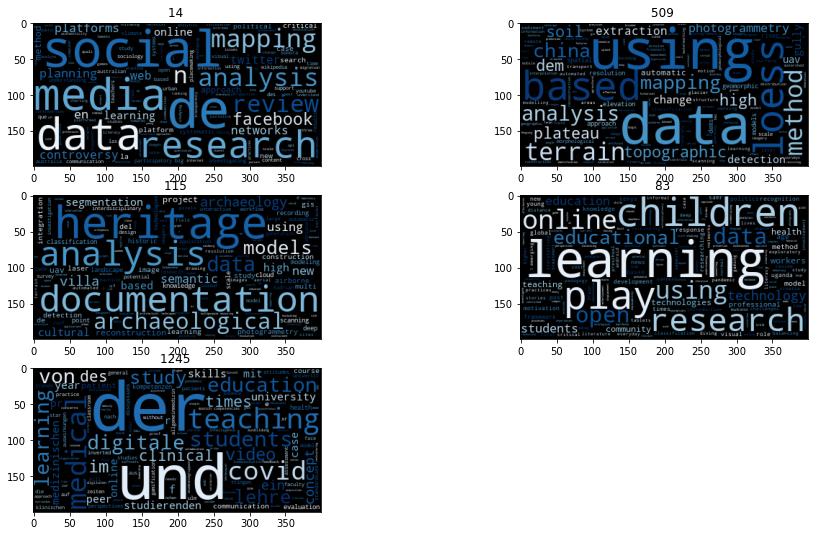

In [44]:
fig = plt.figure(figsize=(16,9))

i = 0
for comm,wc in comm_text_tit.items():
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(wc)
    i = i+1
    ax.set_title(comm)
    # da fare formattazione visiva

In [48]:
wc